In [5]:
%load_ext autoreload
%autoreload 2

Reading 2GB.json (2002000000 bytes) with block size of 4096.
chunksize=4096: 12.69 MiB/sec
chunksize=8192: 1.52 GiB/sec
chunksize=24576: 3.56 GiB/sec
chunksize=98304: 4.8 GiB/sec
Optimal chunksize: 24 KiB
deque([549828476.5833303, 1366808534.3263865, 2124238978.5011094], maxlen=3)
chunksize=491520: 5.19 GiB/sec
Optimal chunksize: 96 KiB
deque([1366808534.3263865, 2124238978.5011094, 2698840726.264438], maxlen=3)
chunksize=2949120: 5.22 GiB/sec
Optimal chunksize: 480 KiB
deque([2124238978.5011094, 2698840726.264438, 3113959137.139859], maxlen=3)
chunksize=20643840: 4.38 GiB/sec
Optimal chunksize: 2.81 MiB
deque([2698840726.264438, 3113959137.139859, 3312331248.413415], maxlen=3)
chunksize=165150720: 2.08 GiB/sec
Optimal chunksize: 19.69 MiB
deque([3113959137.139859, 3312331248.413415, 3192713101.249708], maxlen=3)
chunksize=1486356480: 2.37 GiB/sec
chunksize=14863564800: 1.58 GiB/sec
Optimal chunksize: 1.38 GiB
deque([3192713101.249708, 3127430058.942875, 2997398709.40281], maxlen=3)


/tmp/ipykernel_116268/2251390078.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(list(map(lambda b: humanfriendly.format_size(b, binary=True), chunk_sizes)))


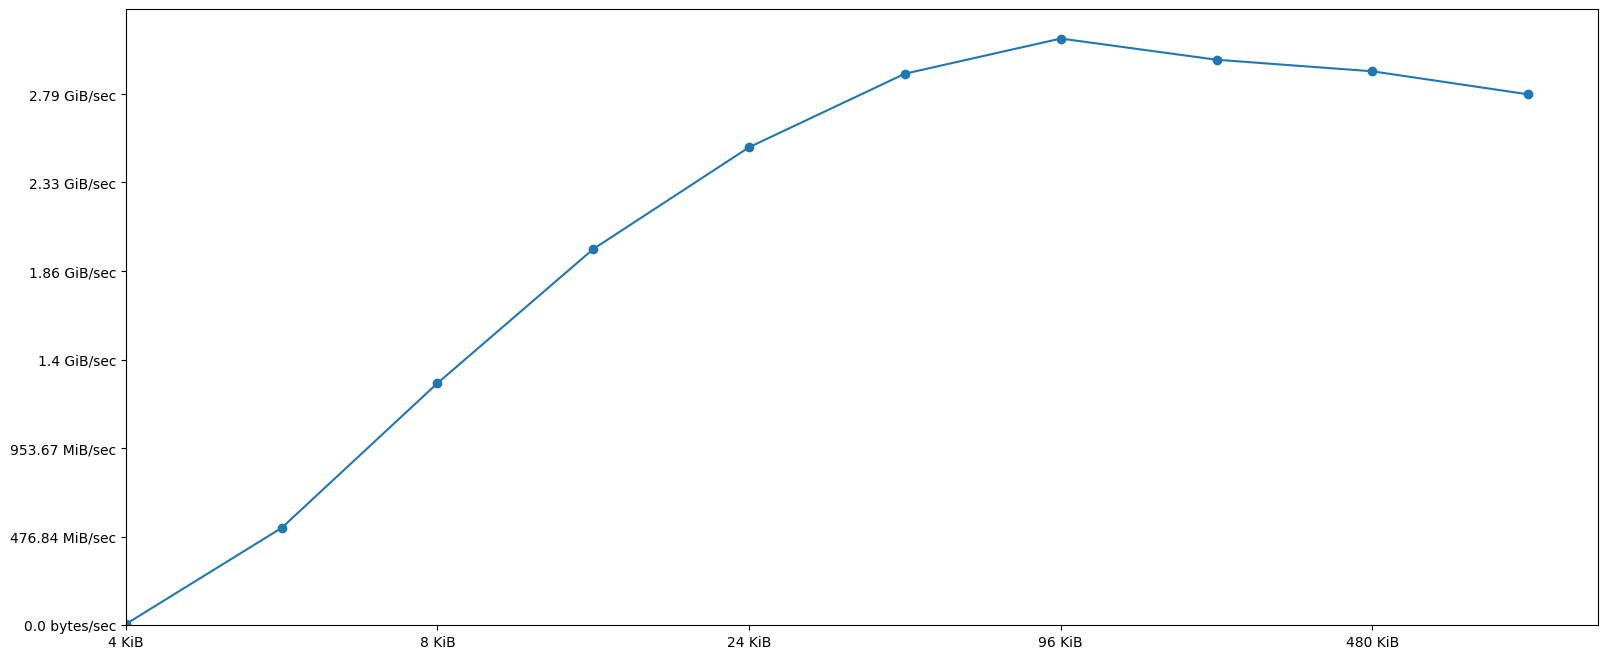

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pathlib
import time
import collections

def moving_average(avg: float, n: int, value: float) -> float:
    return (value + n * avg) / (n + 1)

# from filetoolkit import load

# with load.readlargefile('2GB.json') as file:
#     value = json.load(file)

times = []
sizes = []
avgs = []
chunk_sizes = []
previous_average = 0

average_bitrate_tracker = collections.deque([0] * 3, maxlen=3)

path = pathlib.Path('2GB.json')

initial_chunksize = path.stat().st_blksize

data = b''
with path.open('rb') as file:
    previous_chunksize = 0
    chunksize = initial_chunksize

    increment = 2
    size = path.stat().st_size
    read = 0
    m_avg = 0

    print(f'Reading {path} ({size} bytes) with block size of {initial_chunksize}.')

    while len(data) < size:
        start = time.time()
        chunk = file.read(chunksize)
        duration = time.time() - start
        data += chunk        

        times.append(duration)
        sizes.append(len(data))

        byterate = len(chunk) / duration

        print(f'{chunksize=}: {humanfriendly.format_size(byterate, binary=True)}/sec')

        m_avg = moving_average(avg=m_avg, n=len(times), value=byterate)
        average_bitrate_tracker.append(m_avg)
        if (average_bitrate_tracker[1] - average_bitrate_tracker[0]) > (average_bitrate_tracker[2] - average_bitrate_tracker[1]):
            # Chunk size should be set to the previous chunk size.
            # Rate of growth decreased, suggesting the current chunk size degrades performance.
            print(f'Optimal chunksize: {humanfriendly.format_size(previous_chunksize, binary=True)}')
            print(average_bitrate_tracker)

        avgs.append(m_avg)
        chunk_sizes.append(chunksize)
        
        previous_chunksize = chunksize
        chunksize *= increment
        increment += 1


fig, axes = plt.subplots(figsize=(19, 8))
# axes.plot(sizes, times, 'o-')
axes.plot(list(range(len(avgs))), avgs, 'o-')

axes.set_ylim(bottom=0)
axes.set_xlim(left=0)
import humanfriendly
axes.set_xticklabels(list(map(lambda b: humanfriendly.format_size(b, binary=True), chunk_sizes)))

@ticker.FuncFormatter
def major_formatter(x, pos):
    return f'{humanfriendly.format_size(x, binary=True)}/sec'

axes.yaxis.set_major_formatter(major_formatter)
# axes.set_yticklabels(list(map(lambda b: f'{humanfriendly.format_size(b, binary=True)}/sec', avgs)))


In [7]:
from filetoolkit.load import largefile
import time
from datetime import timedelta
import humanfriendly
import pathlib

p = pathlib.Path('2GB.json')
start = time.time()
with largefile.read('2GB.json') as file:
    v = file.read()

duration = time.time() - start
print(f'Progress bar loading time: {timedelta(seconds=duration)}, {humanfriendly.format_size(p.stat().st_size / duration)}/sec')

start = time.time()
with p.open('rb') as file:
    v = file.read()

duration = time.time() - start
print(f'Typical loading time: {timedelta(seconds=duration)}, {humanfriendly.format_size(p.stat().st_size / duration)}/sec')

Loading 2GB.json: 100%|██████████| 1.86G/1.86G [00:40<00:00, 49.9MB/s]

Progress bar loading time: 0:00:40.133210, 49.88 MB/sec


Typical loading time: 0:00:00.917204, 2.18 GB/sec
